<font face="XB Zar" size=5><div dir=rtl align=center>
<font face="IranNastaliq" size=5>
به نام خدا
</font>
<br>
<font size=3>
دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
</font>
<br>
<font color=blue size=5>
مقدمه‌ای بر یادگیری ماشین
</font>
<br>
<hr/>
<font color=red size=6>
فصل پنج
<br>
Neural Networks 
</font>
<br>
نویسنده:‌ علی رازقندی
<hr>

</div></font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

# Fully-Connected Neural Nets
In this notebook we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

# Affine layer: forward

In [3]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """

    N = x.shape[0]
    D,M = w.shape
    
    input_vectors = x.reshape(N,D)
    
    out = np.matmul(input_vectors,w) + b
    
    return out, (x, w, b)
    

# Affine layer: backward

In [4]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """    
    x,w,b = cache
    
    
    N = x.shape[0]
    D,M = w.shape
    
    dx = np.matmul(dout,w.transpose()).reshape(x.shape)
    dw = np.matmul(x.reshape(N,D).transpose(),dout)
    db = np.sum(dout, axis=0)
    
    
    return dx,dw,db

# ReLU activation: forward

In [5]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    return np.maximum(x,0),x

# ReLU activation: backward

In [6]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dr = cache
    dr[dr<=0] = 0
    dr[dr>0] = 1
    
    return np.multiply(dr,dout)

# Sigmoid activation: forward

In [7]:
def sigmoid_forward(x):
    """
    Computes the forward pass for a layer of Sigmoid.

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """

    out = np.divide(np.exp(x), np.exp(x) + 1)
    return out, x

# Sigmoid activation: backward

In [8]:
def sigmoid_backward(dout, cache):
    """
    Computes the backward pass for a layer of Sigmoid.

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    out,_ = sigmoid_forward(cache)
    ds = out * (1-out)
    
    return np.multiply(ds,dout)

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity.here is the Implementation of the forward and backward pass for the affine layer followed by a ReLU nonlinearity in the `affine_relu_forward` and `affine_relu_backward` functions. 

In [9]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    
    affine_out, affine_cache = affine_forward(x, w, b)
    
    relu_out, relu_cache = relu_forward(affine_out)
    
    return relu_out, (*affine_cache,relu_cache)
    

In [10]:
def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    
    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (fc_cache, relu_cache)
      
    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    x, w, b, relu_input = cache
    
    relu_backward_out = relu_backward(dout, relu_input)
    dx, dw, db = affine_backward(relu_backward_out, (x, w, b))
    
    return dx, dw, db

# Batch Normalization: Forward Pass


In [11]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        data_mean = np.mean(x, axis=0)
        data_var = np.var(x, axis=0)
        
        running_mean = momentum * running_mean + (1 - momentum) * data_mean
        running_var = momentum * running_var + (1 - momentum) * data_var
        
        normilized_data = (x - data_mean) / np.sqrt(data_var + eps)
        out = normilized_data * gamma + beta
        cache = (x, gamma, beta, bn_param, normilized_data)

    elif mode == "test":

        normilized_data = (x - running_mean) / np.sqrt(running_var + eps)
        out = normilized_data * gamma + beta
        cache = (x, gamma, beta, bn_param, normilized_data)

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

# Batch Normalization: Backward Pass
Now here is the implementation of the backward pass for batch normalization in the function `batchnorm_backward`.

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $var$.
With $\mu$ and $var$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  var=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG">

---


<img src="https://kratzert.github.io/images/bn_backpass/BNcircuit.png">




In [12]:
def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    
    x, gamma, beta, bn_param, normilized_data = cache
    eps = bn_param.get("eps", 1e-5)
    dbeta = np.sum(dout, axis=0)
    dgamma = np.multiply(normilized_data, dout).sum(axis=0)
    
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    std = np.sqrt(var+eps)
    
    n,d = dout.shape
    
    coef = gamma * dout    
    
    d_isigma = np.sum(coef * (x-mean), axis=0)
    dxmu1 = coef / std

  
    dsigma = -1. /(std**2) * d_isigma

  
    dvar = 0.5 * 1 /std * dsigma

  
    dsq = 1 /n * np.ones((n,d)) * dvar

  
    dxmu2 = 2 * (x - mean) * dsq

    
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

    
    dx2 = 1. /n * np.ones((n,d)) * dmu

    
    dx = dx1 + dx2
    
    
    return dx,dgamma,dbeta

# Loss layer: Softmax

In [13]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    n = y.shape[0]
    p = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
    log_likelihood = -np.log(p[range(n),y])
    loss = np.sum(log_likelihood) / n
    
    p[range(n),y] -= 1
    dx = p/n
    
    return loss,dx

# Loss layer: MSE

In [15]:
def mse_loss(x, y):
    """
    Computes the loss and gradient for MSE loss.

    Inputs:
    - x: Input data, of shape (N,) where x[i] is the predicted vector for 
        the ith input.
    - y: Vector of target values, of shape (N,) where y[i] is the target value
        for the ith input.

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    n = x.shape[0]
    
    x = x.flatten()
    y = y.flatten()
    
    MSE = ((y - x)**2).sum() / n
    
    dx = 2 * (x-y) / n
    
    return MSE,dx

# Multi-Layer Fully Connected Network

In [16]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function for a classification problem or the MSE loss function for 
    a regression problem. This will also implement batch normalization as an option. 
    For a network with L layers, the architecture will be

    {affine - [batchnorm] - relu} x (L - 1) - affine - softmax/mse

    where batch normalization is optional in each layer and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        category,
        hidden_dims,
        normalization,
        input_dim=784,
        output_dim=10,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - category: The type of the problem. Valid values are "classification",
            "regression".
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - normalization: A list of booleans which shows that we have batch 
            normalization after the affine layer.
        - input_dim: An integer giving the size of the input.
        - output_dim: An integer giving the number of classes to classify. It
            is 1 for a regression problem.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        """
        self.category = category
        self.normalization = normalization
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
        
        last_no_number = input_dim
        
        for i in range(len(hidden_dims)):
            weight_key = 'w' + str(i+1)
            bias_key = 'b' + str(i+1)
            no_node = hidden_dims[i]
            
            weights = np.random.normal(0, weight_scale, size=(last_no_number, no_node))
            biases = np.zeros(no_node)
            
            last_no_number = no_node
            
            self.params[weight_key] = weights
            self.params[bias_key] = biases
            
            if normalization[i]:
                gamma_key = 'gamma' + str(i+1)
                beta_key = 'beta' + str(i+1)
                
                self.params[gamma_key] = np.ones(no_node)
                self.params[beta_key] = np.zeros(no_node)
        
        weight_key = 'w' + str(self.num_layers)
        bias_key = 'b' + str(self.num_layers)
        
        weights = np.random.normal(0, weight_scale, size=(last_no_number, output_dim))
        biases = np.zeros(output_dim)
            
        self.params[weight_key] = weights
        self.params[bias_key] = biases

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.

        self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels / target values, of shape (N,). y[i] gives the 
            label / target value for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return
        scores for a classification problem or the predicted_values for 
        a regression problem:
        - out: Array of shape (N, C) / (N, ) giving classification scores / predicted values, where 
        scores[i, c] is the classification score for X[i] and class c / predicted_values[i]
        is the predicted value for X[i].
            

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params since they
        # behave differently during training and testing.
        for bn_param in self.bn_params:
            bn_param["mode"] = mode

        cache_list = list()
        data = X
        for i in range(self.num_layers - 1):
            
            cache_list.append(dict())
            
            weights = self.params['w'+str(i+1)]
            biases = self.params['b'+str(i+1)]
            
            data, affine_cache = affine_forward(data, weights, biases)
            
            cache_list[i]["affine_cache"] = affine_cache
            
            if self.normalization[i]:
                gamma = self.params['gamma' + str(i+1)]
                beta = self.params['beta' + str(i+1)]
                data, batch_cache = batchnorm_forward(data, gamma, beta, self.bn_params[i])
                
                cache_list[i]["batch_cache"] = batch_cache
                
            data, relu_cache = relu_forward(data)
            cache_list[i]["relu_cache"] = relu_cache
        
        
        weight_key = 'w' + str(self.num_layers)
        bias_key = 'b' + str(self.num_layers)
            
        weights = self.params[weight_key] 
        biases = self.params[bias_key]
        
        out, affine_cache = affine_forward(data, weights, biases)
        cache_list.append(dict())
        
        cache_list[-1]["affine_cache"] = affine_cache   

        # If test mode return early.
        if mode == "test":
            return out
            
        loss, grads = 0.0, {}
      
        if self.category == 'classification':
            loss, loss_grad = softmax_loss(out, y)
        else:
            loss, loss_grad = mse_loss(out, y)
            loss_grad = np.reshape(loss_grad, (-1, 1))
            
        
        for i in range(self.num_layers):
            w = self.params['w'+str(i+1)]
            loss += 0.5 * self.reg * np.sum(w * w) 

        # calculate gradients
        dout = loss_grad
        affine_cache = cache_list[-1]["affine_cache"]
        
        dout, dw, db = affine_backward(dout, affine_cache)
        grads['w' + str(self.num_layers)] = dw + self.reg * self.params['w' + str(self.num_layers)]
        grads['b' + str(self.num_layers)] = db
        
        
        for i in range(self.num_layers - 2, -1, -1):
            relu_cache = cache_list[i]["relu_cache"]
            dx = relu_backward(dout, relu_cache)
            
            if self.normalization[i]:
                batch_cache = cache_list[i]["batch_cache"]
                dx,dgamma,dbeta = batchnorm_backward(dx, batch_cache)
                grads['gamma'+str(i+1)] = dgamma
                grads['beta' +str(i+1)] = dbeta
            
            affine_cache = cache_list[i]["affine_cache"]
            dx, dw, db = affine_backward(dx, affine_cache)
                
            grads['w' + str(i + 1)] = dw + self.reg * self.params['w' + str(i + 1)]
            grads['b' + str(i + 1)] = db
            dout = dx
            
        return loss, grads

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Here is the implementation of the SGD+momentum update rule in the function `sgd_momentum`.

In [17]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.
    Inputs:
    - w: A numpy array giving the current weights.
    - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
    - config: A dictionary containing hyperparameter values such as learning
    rate, momentum.

    Returns:
      - next_w: The next point after the update.
      - config: The config dictionary to be passed to the next iteration of the
        update rule.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces sgd_momentum to stochastic gradient descent.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    next_w = None

    v = config['momentum'] * v - config['learning_rate'] * dw
    next_w = w + v

    config["velocity"] = v

    return next_w, config

# MNIST
MNIST is a widely used dataset of handwritten digits that contains 60,000 handwritten digits for training a machine learning model and 10,000 handwritten digits for testing the model.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


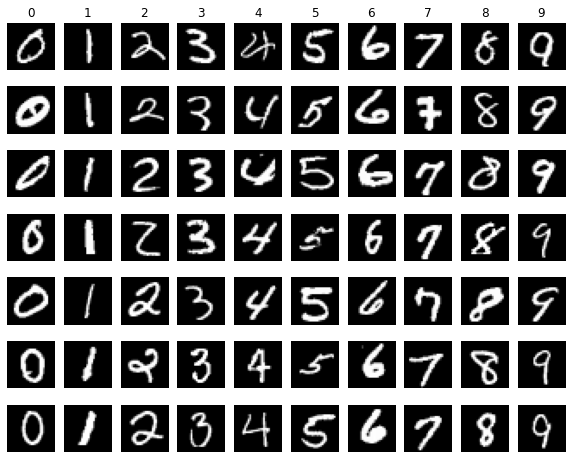

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(range(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Data normalization is an important step which ensures that each input parameter has a similar data distribution. This makes convergence faster while training the network.

In [ ]:
X_train, X_val, X_test = get_normalized_MNIST_data(X_train, X_val, X_test)

# Train a Good Model!
Open the file `solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train the best fully connected model that you can on MNIST, storing your best model in the `MNIST_best_model` variable. We require you to get at least 95% accuracy on the validation set using a fully connected network.

In [ ]:
MNIST_best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on MNIST. You might      #
# find batch normalization. Store your best model in                           #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    'classification', 
    [120, 100,80],
    [False, True,True],
    dtype=np.float64
)
solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

MNIST_solver = solver
MNIST_best_model = model

(Iteration 1 / 1250) loss: 2.305886
(Epoch 0 / 5) train acc: 0.074000; val_acc: 0.086300
(Iteration 101 / 1250) loss: 1.172810
(Iteration 201 / 1250) loss: 0.472909
(Epoch 1 / 5) train acc: 0.939000; val_acc: 0.946200
(Iteration 301 / 1250) loss: 0.297350
(Iteration 401 / 1250) loss: 0.226044
(Epoch 2 / 5) train acc: 0.971000; val_acc: 0.966000
(Iteration 501 / 1250) loss: 0.194716
(Iteration 601 / 1250) loss: 0.130659
(Iteration 701 / 1250) loss: 0.135241
(Epoch 3 / 5) train acc: 0.985000; val_acc: 0.970800
(Iteration 801 / 1250) loss: 0.109035
(Iteration 901 / 1250) loss: 0.097759
(Epoch 4 / 5) train acc: 0.989000; val_acc: 0.973300
(Iteration 1001 / 1250) loss: 0.124812
(Iteration 1101 / 1250) loss: 0.094500
(Iteration 1201 / 1250) loss: 0.056207
(Epoch 5 / 5) train acc: 0.989000; val_acc: 0.976300


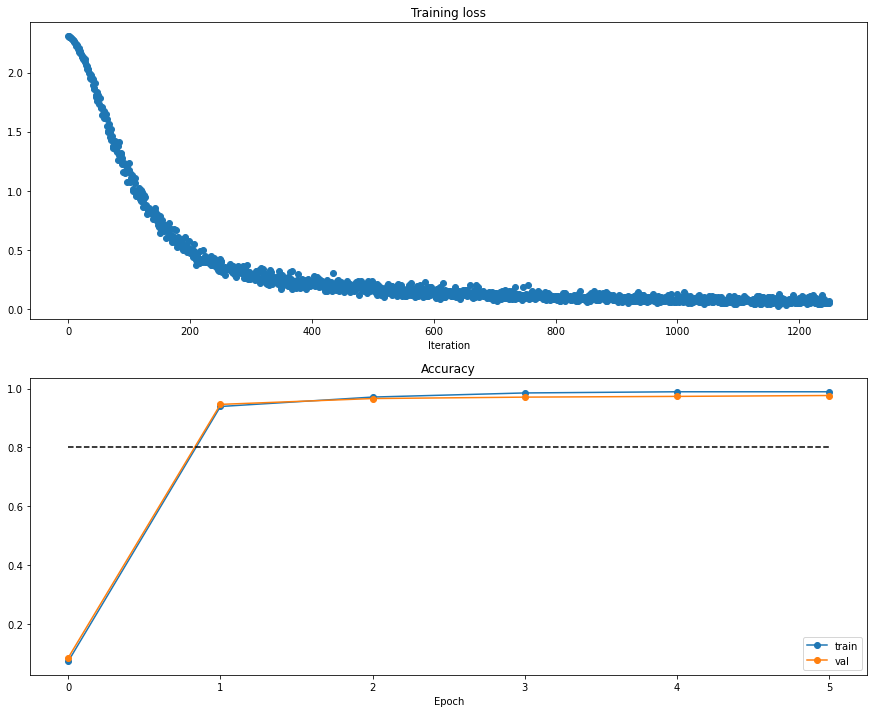

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(MNIST_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(MNIST_solver.train_acc_history, '-o', label='train')
plt.plot(MNIST_solver.val_acc_history, '-o', label='val')
plt.plot([0.8] * len(MNIST_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 95% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(MNIST_best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(MNIST_best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9763
Test set accuracy:  0.9733


# California housing dataset
This is a dataset obtained from the [StatLib repository](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.

In [ ]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_california_housing_data()
print('Train data shape: ', X_train.shape)
print('Train target values shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation target values shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test target values shape: ', y_test.shape)

Train data shape:  (15640, 8)
Train target values shape:  (15640,)
Validation data shape:  (2500, 8)
Validation target values shape:  (2500,)
Test data shape:  (2500, 8)
Test target values shape:  (2500,)


In [ ]:
X_train, X_val, X_test = get_california_housing_normalized__data(X_train, X_val, X_test)

# Train a Good Model!
Train the best fully connected model that you can on california housing, storing your best model in the `california_housing_best_model` variable.

In [ ]:
california_housing_best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on california housing.   #
# You might find batch normalization useful. Store your best model in          #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
    }

model = FullyConnectedNet(
    'regression', 
    [120, 100, 80],
    [False, True,True],
    input_dim=8,
    output_dim=1,
    dtype=np.float64
)
solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

california_housing_solver = solver
california_housing_best_model = model

(Iteration 1 / 390) loss: 3.249017
(Epoch 0 / 5) train RMS error: 2.000721; val RMS error: 2.600033
(Epoch 1 / 5) train RMS error: 1.206121; val RMS error: 1.552999
(Iteration 101 / 390) loss: 1.670250
(Epoch 2 / 5) train RMS error: 1.284745; val RMS error: 1.529322
(Iteration 201 / 390) loss: 1.550910
(Epoch 3 / 5) train RMS error: 1.225156; val RMS error: 1.519381
(Iteration 301 / 390) loss: 1.434795
(Epoch 4 / 5) train RMS error: 1.180216; val RMS error: 1.542903
(Epoch 5 / 5) train RMS error: 1.199541; val RMS error: 1.542804


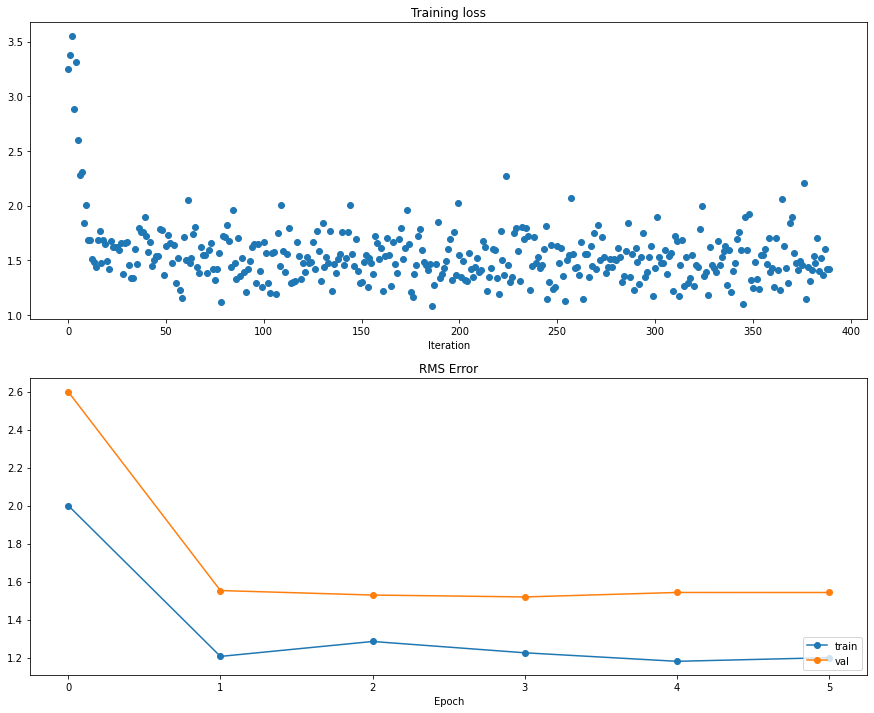

In [ ]:
# Run this cell to visualize training loss and train / val RMS error

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(california_housing_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('RMS Error')
plt.plot(california_housing_solver.train_acc_history, '-o', label='train')
plt.plot(california_housing_solver.val_acc_history, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()